In [1]:
import pqr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prices = pd.read_csv("./data/moex_prices.csv", index_col="Date", parse_dates=True)
volume = pd.read_csv("./data/moex_volume.csv", index_col="Date", parse_dates=True)

In [3]:
evaluate = pqr.freeze(pqr.evaluate, universe_returns=pqr.to_returns(prices))

In [4]:
mom = pqr.compose(
    pqr.freeze(pqr.look_back, period=3, agg="pct"),
    pqr.freeze(pqr.lag, period=1),
    pqr.freeze(pqr.hold, period=3),
)(prices)
vol = pqr.compose(
    pqr.freeze(pqr.look_back, period=3, agg="mean"),
    pqr.freeze(pqr.lag, period=1),
    pqr.freeze(pqr.hold, period=3),
)(volume)

In [5]:
mom_signals = pqr.quantiles(mom, min_q=0.8, max_q=1)
vol_signals = pqr.quantiles(vol, min_q=0.8, max_q=1)

mom_holdings = pqr.ew(mom_signals)
vol_holdings = pqr.ew(vol_signals)

mom_returns = evaluate(mom_holdings)
vol_returns = evaluate(vol_holdings)

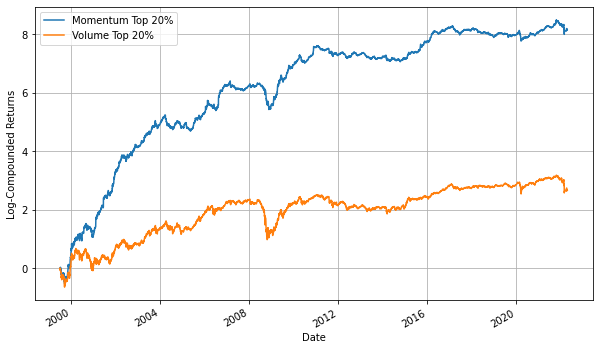

In [6]:
def log_compounded(r: pd.Series) -> pd.Series:
    compounded = (1 + r).cumprod()
    return np.log(compounded)


plt.figure(figsize=(10, 6))

log_compounded(mom_returns).plot(label="Momentum Top 20%")
log_compounded(vol_returns).plot(label="Volume Top 20%")

plt.xlabel("Date")
plt.ylabel("Log-Compounded Returns")
plt.grid()
plt.legend(); 

In [7]:
weighted_holdings = (mom_holdings + vol_holdings) / 2
weighted_returns = evaluate(weighted_holdings)

In [8]:
intercept_signals = mom_signals & vol_signals  
intercept_holdings = pqr.ew(intercept_signals)
intercept_returns = evaluate(intercept_holdings)

In [9]:
mom_than_vol_signals = pqr.compose(
    pqr.freeze(pqr.filter, universe=mom_signals),
    pqr.freeze(pqr.quantiles, min_q=0.5, max_q=0.5)
)(vol)
mom_than_vol_holdings = pqr.ew(mom_than_vol_signals)
mom_than_vol_returns = evaluate(mom_than_vol_holdings)

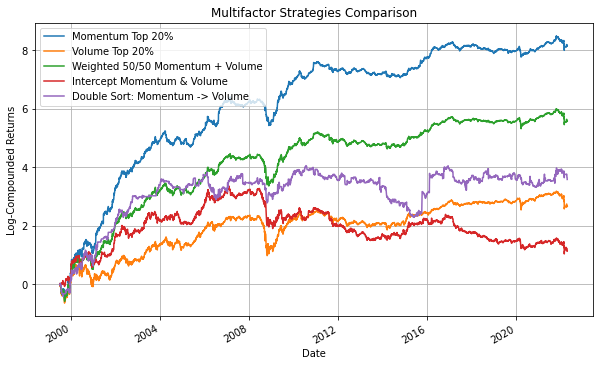

In [10]:
plt.figure(figsize=(10, 6))

log_compounded(mom_returns).plot(label="Momentum Top 20%")
log_compounded(vol_returns).plot(label="Volume Top 20%")
log_compounded(weighted_returns).plot(label="Weighted 50/50 Momentum + Volume")
log_compounded(intercept_returns).plot(label="Intercept Momentum & Volume")
log_compounded(mom_than_vol_returns).plot(label="Double Sort: Momentum -> Volume")

plt.title("Multifactor Strategies Comparison")
plt.xlabel("Date")
plt.ylabel("Log-Compounded Returns")
plt.grid()
plt.legend(); 